<a href="https://colab.research.google.com/github/pgupta7/Bayesian-Dynamic-modeling-on-the-Google-search-trends-for-Cricket/blob/main/Normal_dynamic_linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Bayesian predictive model for the search hits of the word cricket.

In this project, we make a predictive model for the word cricket appearing in google hits.

In [ ]:
install.packages("gtrendsR")
install.packages("dlm")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BH’, ‘anytime’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



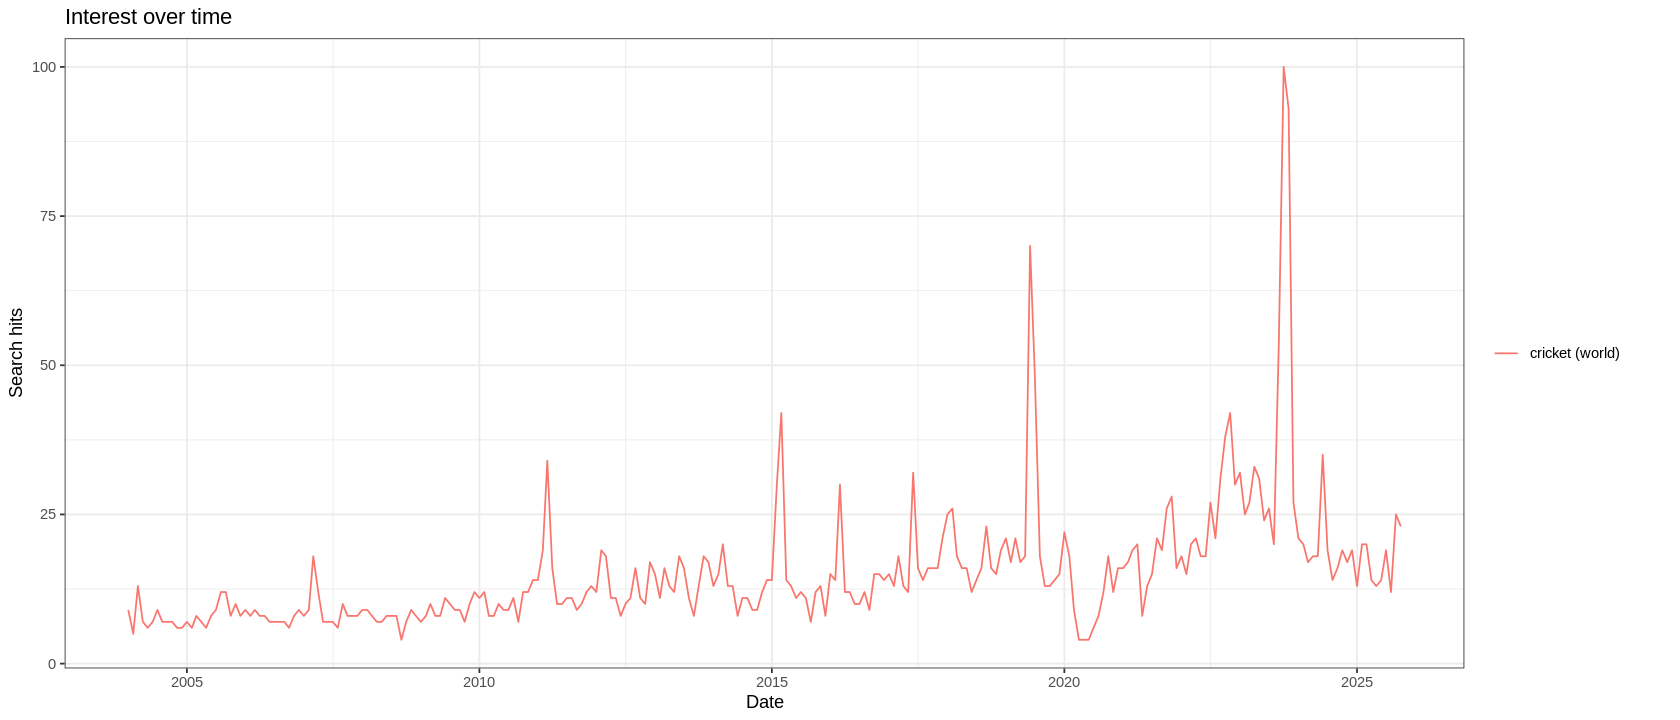

In [ ]:
library(gtrendsR)
timeseries_data<-gtrends("cricket",time="all")
plot(timeseries_data)

timeseries_data=timeseries_data$interest_over_time
timeseries_data$hits = as.numeric(timeseries_data$hits)
# timeseries_data$hits[is.na(timeseries_data$hits)] <- 0
data=list(yt=timeseries_data$hits)



We can see that there are peaks in the dat, which come around 2023, 2019, 2015, 2011, 2007, and 2003(relatively smnall but still visible). These peaks coincide with the the men's ODI cricket world cup events. This implies that we will keep a period of 48 months in our model.


Moreover, since 2011 the number of sceondary peaks between two cricket world cups have also increased. This is likely due to the increase in the number of cricket formats and the associated events. For example, T-20 cricket world cups (every 4 years but not coiding with the ODI men's cricket world cup), women's world cup, ICC champions trophy, etc. These world events are usually played in separate years, but they repeat at 4-year intervals. This imply that after 2011, the trend should have a big component for 36, 24 and 12-month periods as well.

Since 2011 there have been many annual domestic leagues in various countries, likely contributing to various closely spaces peaks appearing since 2011. We will consider frequencies upto a 4-month period to accoount for all the lesser popular but more frequenct events.

Finally, we see a general increase in the cricket hits over the years, which we will model using an order-2 AR process.




Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Backward smoothing is completed!
[1] "The selected discount factor: 0.96"


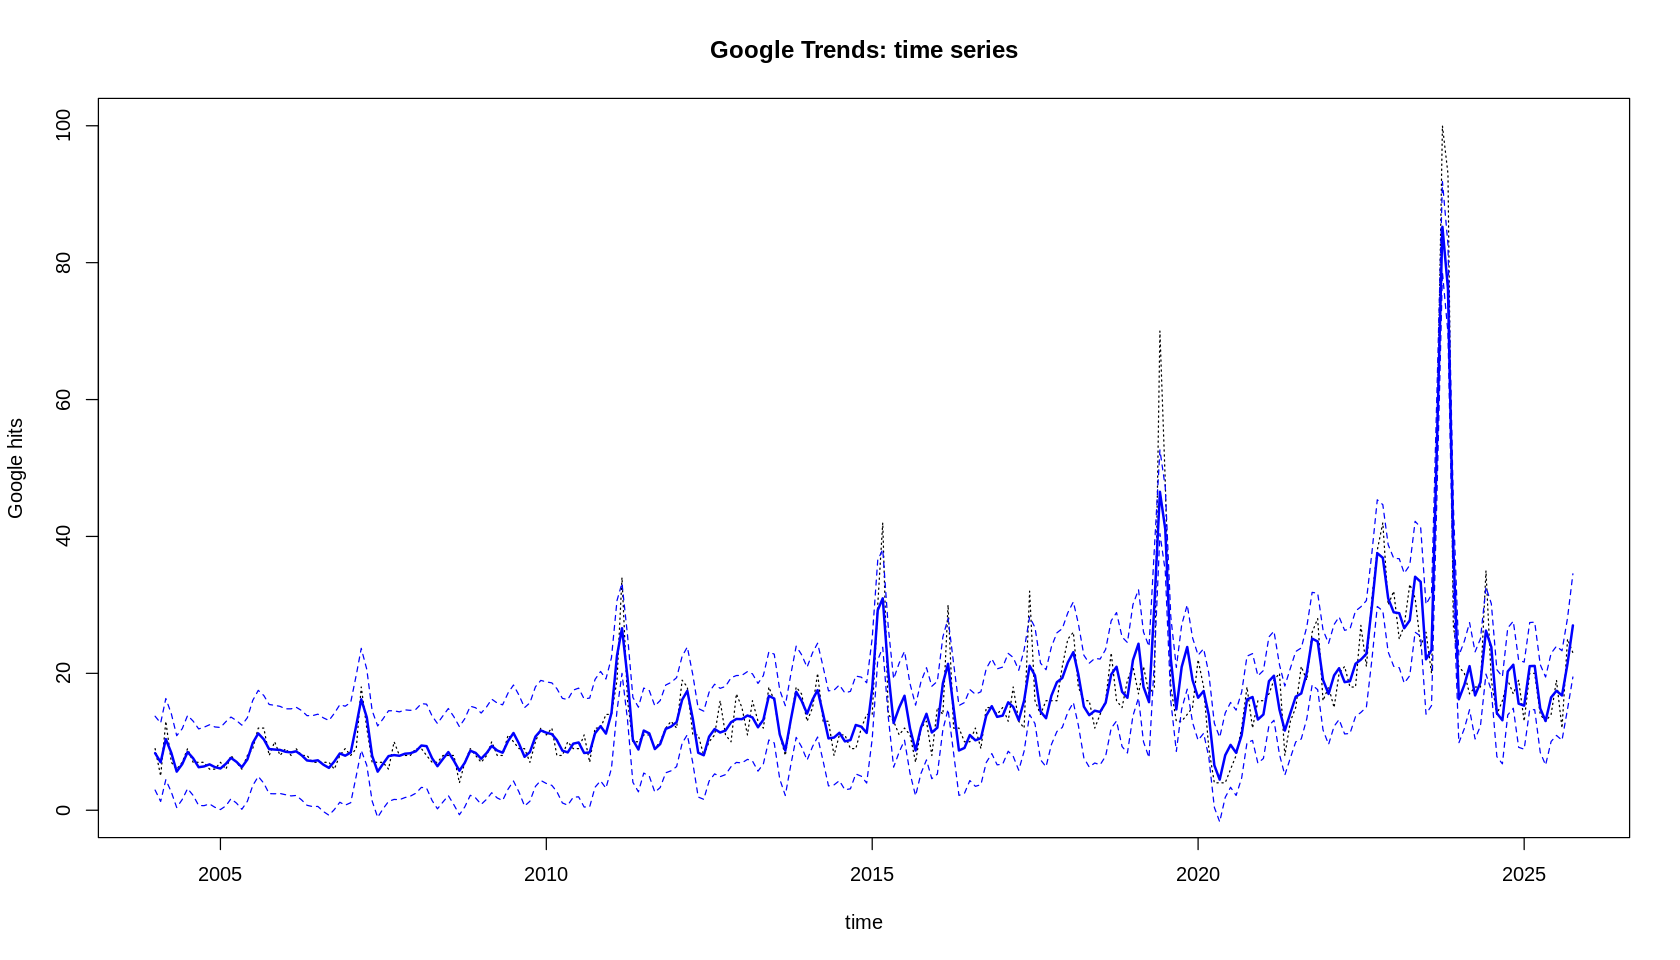

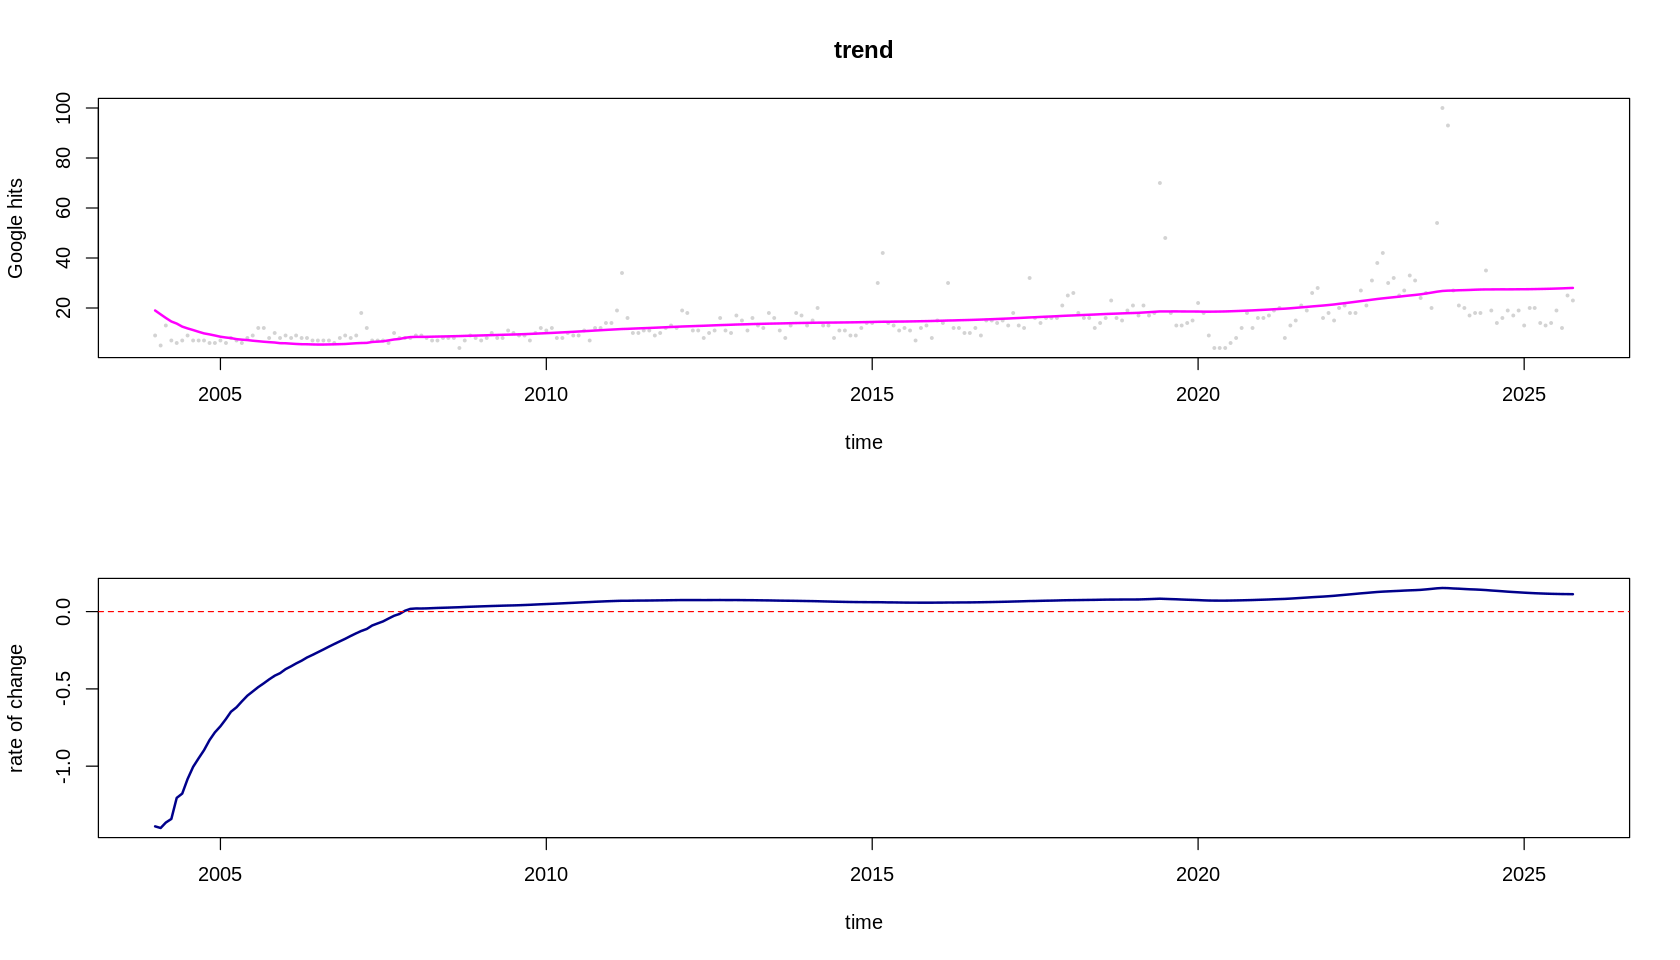

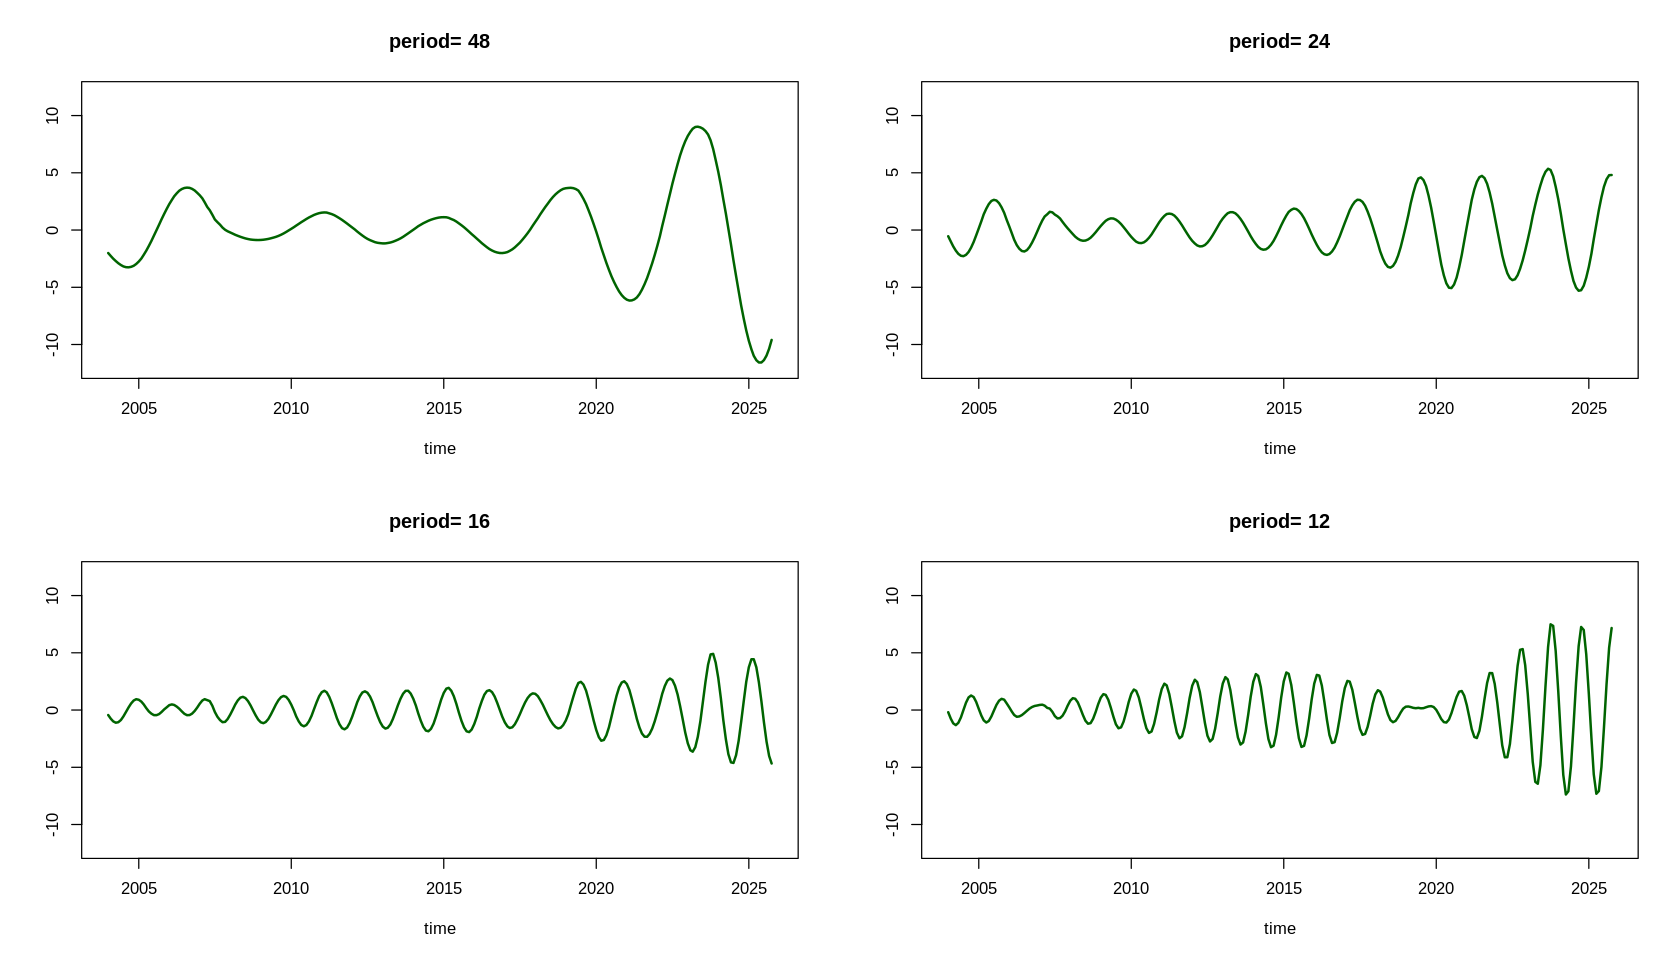

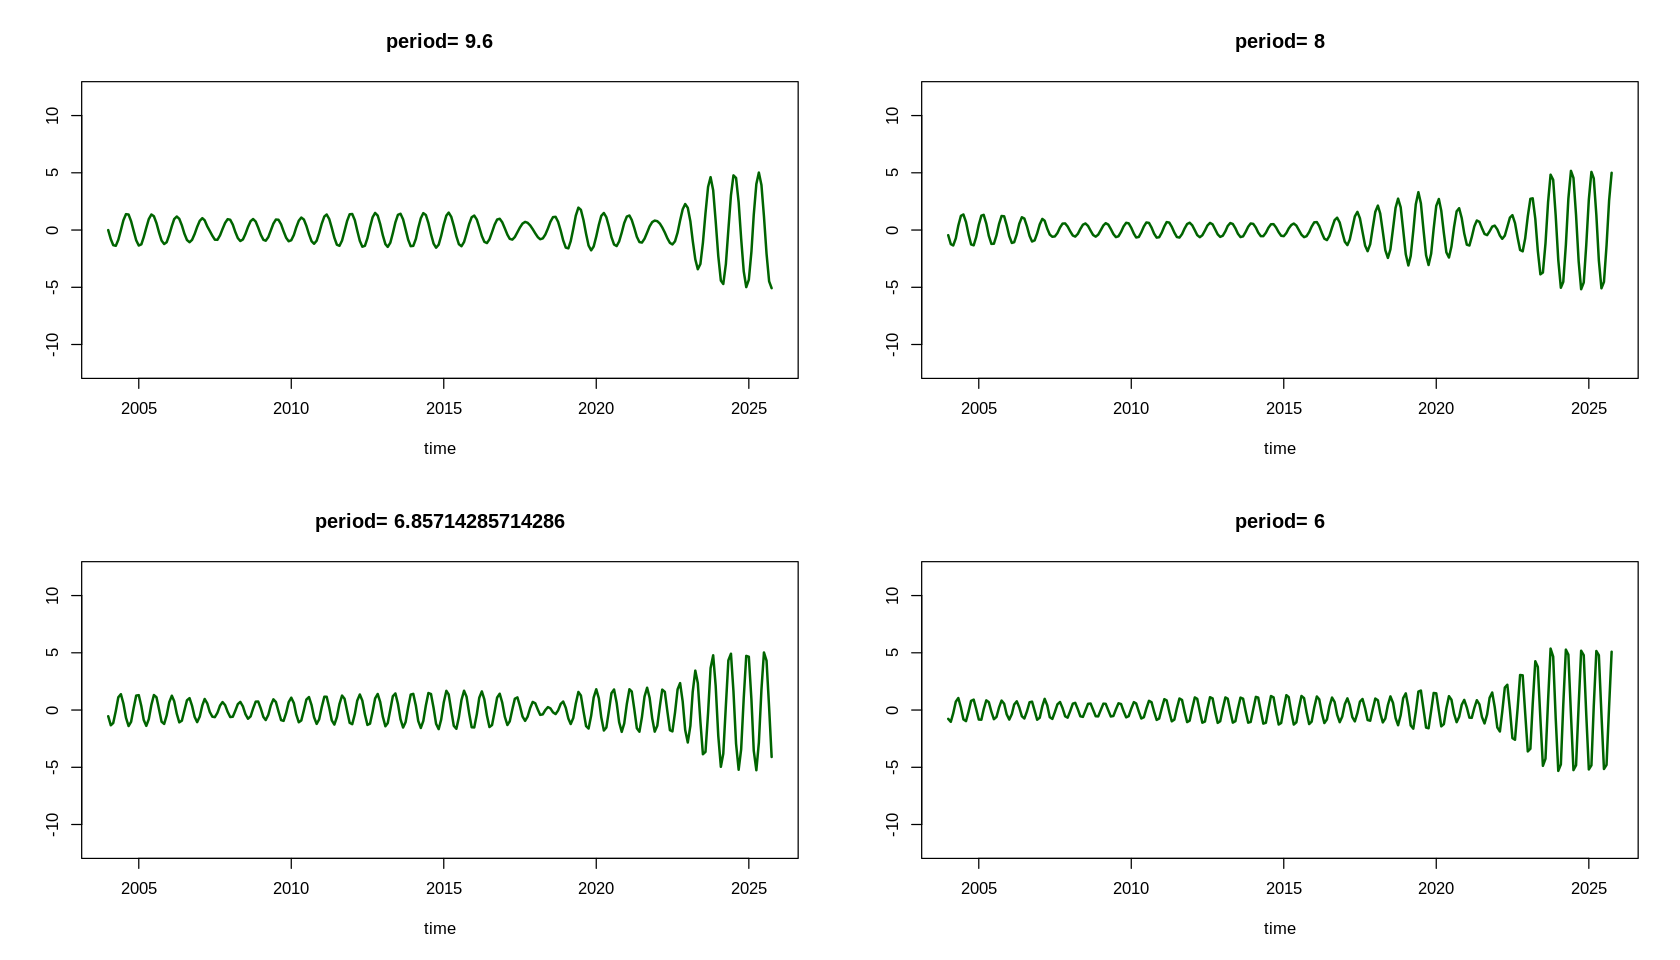

[1] 22.40167

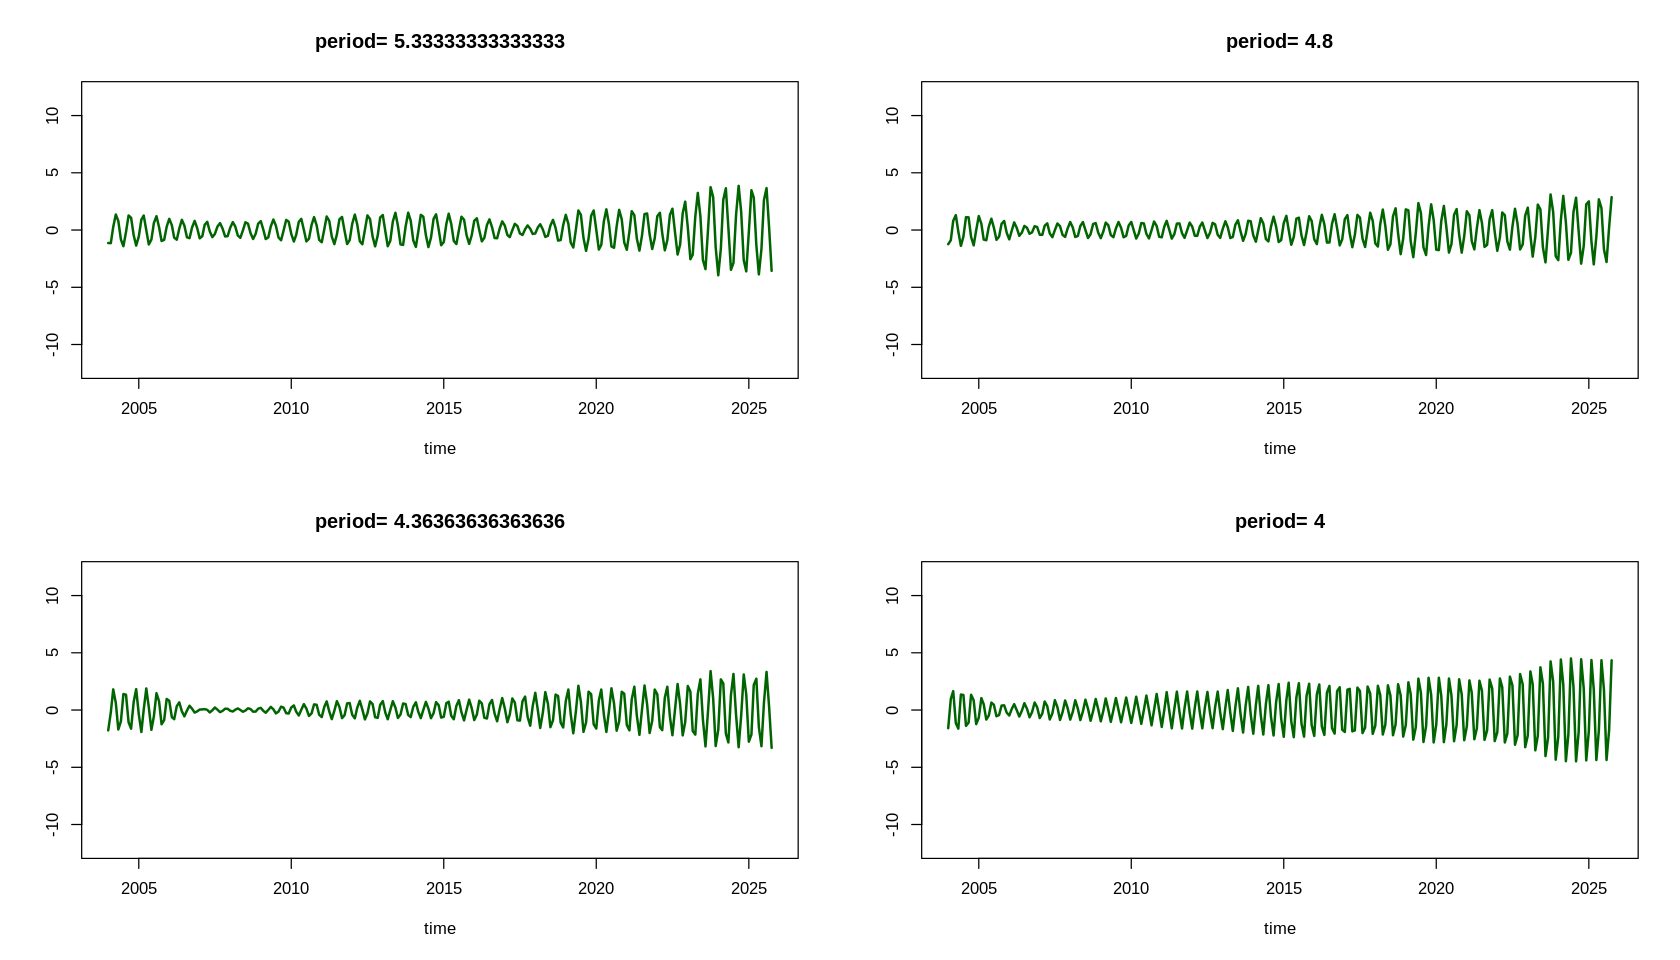

In [158]:
# download data


library(dlm)
model_seasonal=dlmModTrig(s=48,q=12, dV=0,dW=1)
model_trend=dlmModPoly(order=2,dV=10,dW=rep(1,2),m0=c(25,0))
model=model_trend+model_seasonal
# model = model_seasonal
model$C0=10*diag(26)
n0=1
S0=10
k=length(model$m0)
T=length(data$yt)

Ft=array(0,c(1,k,T))
Gt=array(0,c(k,k,T))
for(t in 1:T){
   Ft[,,t]=model$FF
   Gt[,,t]=model$GG
}

source('all_dlm_functions_unknown_v.R')
source('discountfactor_selection_functions.R')

matrices=set_up_dlm_matrices_unknown_v(Ft=Ft,Gt=Gt)
initial_states=set_up_initial_states_unknown_v(model$m0,
                                               model$C0,n0,S0)

df_range=seq(0.9,1,by=0.005)

## fit discount DLM
## MSE
results_MSE <- adaptive_dlm(data, matrices,
               initial_states, df_range,"MSE",forecast=FALSE)

## print selected discount factor
print(paste("The selected discount factor:",results_MSE$df_opt))

## retrieve filtered results
results_filtered <- results_MSE$results_filtered
ci_filtered <- get_credible_interval_unknown_v(
  results_filtered$ft,results_filtered$Qt,results_filtered$nt)

## retrieve smoothed results
results_smoothed <- results_MSE$results_smoothed
ci_smoothed <- get_credible_interval_unknown_v(
  results_smoothed$fnt, results_smoothed$Qnt,
  results_filtered$nt[length(results_smoothed$fnt)])

## plot smoothing results
options(repr.plot.width = 14, repr.plot.height = 8)
par(mfrow=c(1,1))
index <- timeseries_data$date
plot(index, data$yt, ylab='Google hits',
     main = "Google Trends: time series", type = 'l',
     xlab = 'time', lty=3,ylim=c(0,100))
lines(index, results_smoothed$fnt, type = 'l', col='blue',
      lwd=2)
lines(index, ci_smoothed[, 1], type='l', col='blue', lty=2)
lines(index, ci_smoothed[, 2], type='l', col='blue', lty=2)

# Plot trend and rate of change
par(mfrow=c(2,1))
plot(index,data$yt,pch=19,cex=0.3,col='lightgray',xlab="time",
     ylab="Google hits",main="trend")
lines(index,results_smoothed$mnt[,1],lwd=2,col='magenta')
plot(index,results_smoothed$mnt[,2],col='darkblue',lwd=2,
     type='l', xlab="time",
     ylab="rate of change")
abline(h=0,col='red',lty=2)

# Plot seasonal components
par(mfrow=c(2,2))

for(i in seq(3,26, 2)){
  plot(index,results_smoothed$mnt[,i],lwd=2,col="darkgreen",
     type='l', xlab="time",ylab="",main=paste0("period= ", 48*2/(i-1)),
     ylim=c(-12,12))
}


#Estimate for the observational variance: St[T]
results_filtered$St[T]


In [ ]:
library("tidyverse")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()  masks dlm::%+%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
df = as.data.frame(results_filtered$mt)
p = ggplot(df, aes(x = index, y = results_smoothed$mnt[,3])) + geom_line()
p + geom_line(x = index, y = results_smoothed$mnt[,5])

ERROR while rich displaying an object: Error in `geom_line()`:
! Problem while setting up geom.
ℹ Error occurred in the 2nd layer.
Caused by error in `order()`:
! argument 3 is not a vector

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(r

In [ ]:
df_long = pivot_longer(df, cols = c(1,2), names_to = "phis", values_to = "values")

In [ ]:
df = as.data.frame(results_filtered$mt)
df$index = index
colnums = seq(3, 26, 2)
df_long = pivot_longer(df, cols = colnums, names_to = "phis", values_to = "values")[c("index","phis", "values")]
df_long$period = 48*2/(as.numeric(substring(df_long$phis,2))-1)


In [ ]:
install.packages("paletteer")
library(paletteer)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘prismatic’




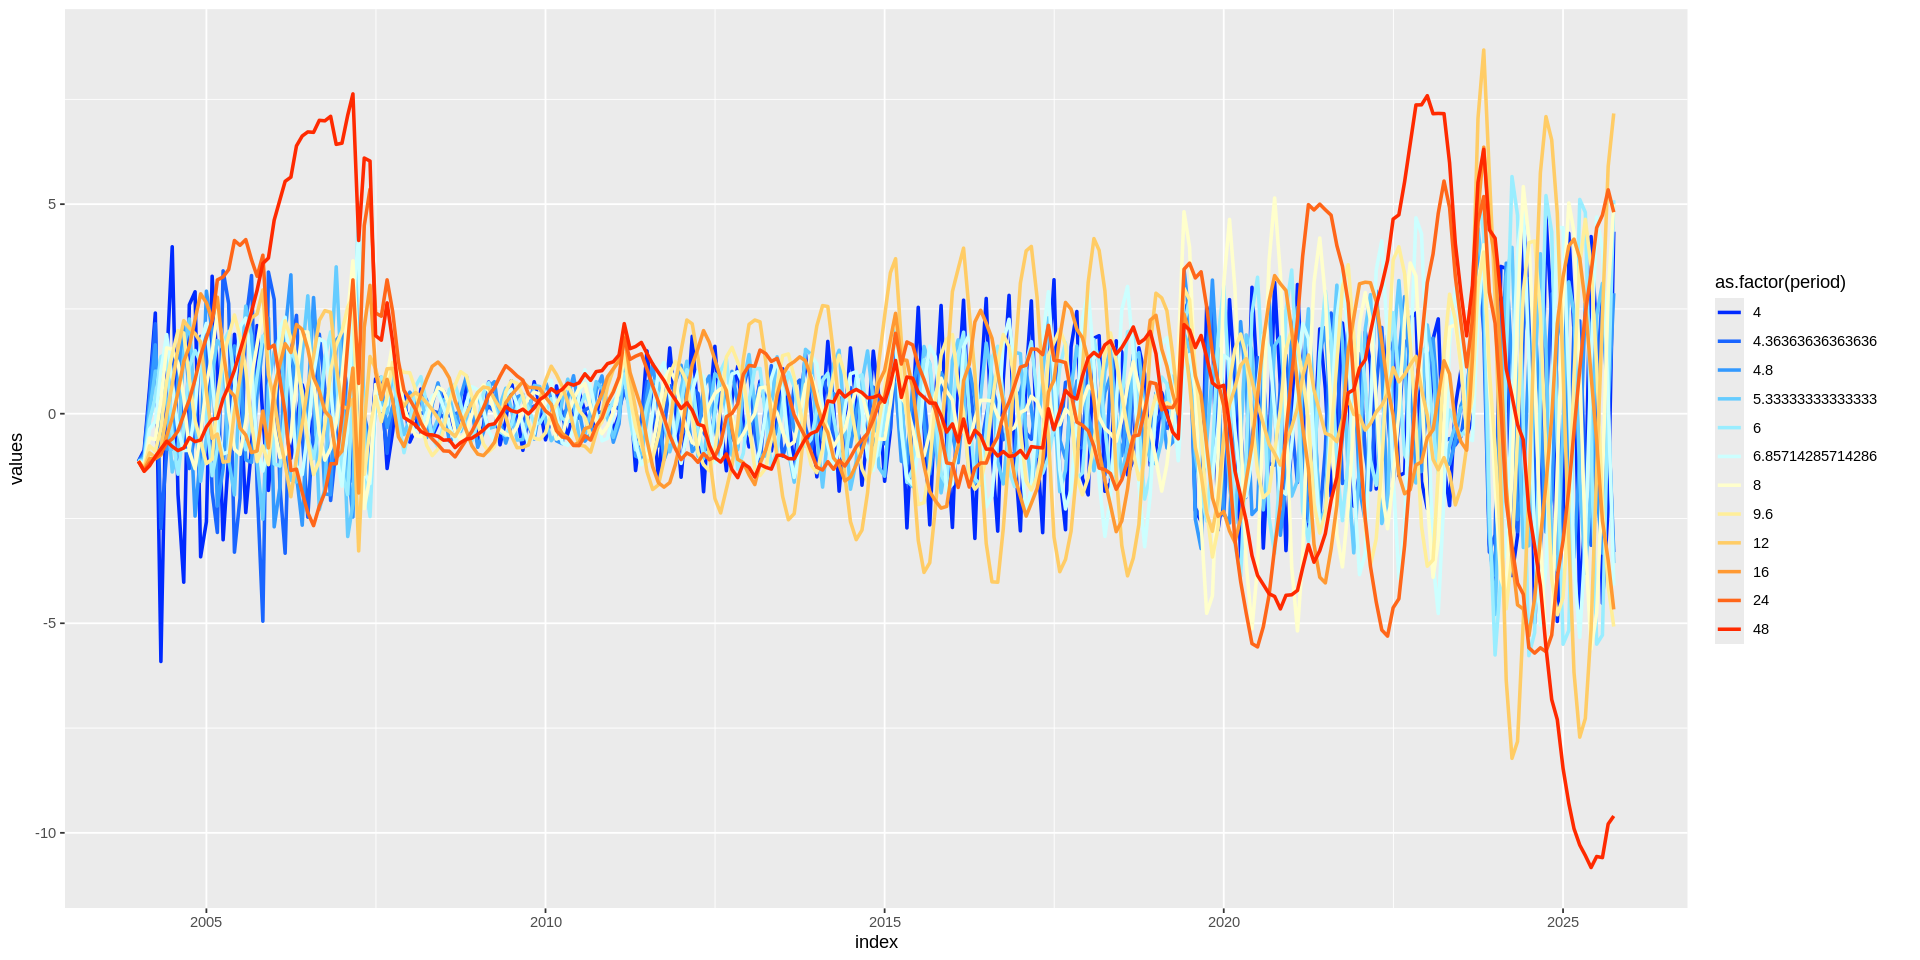

In [ ]:
# col = c(rep(paletteer_d("MoMAColors::Abbott")[5],8), rep(paletteer_d("MoMAColors::Abbott")[1],4))
options(repr.plot.width = 16)
col = paletteer_d("colorBlindness::Blue2Orange12Steps")
ggplot(data = df_long, aes(x = index, y = values, color = as.factor(period)))+
  geom_line(linewidth = 1)+
  scale_color_manual(values = col[1:12])

We see from the above plot that the biggest contributors to the data include periods of 48, 24, 12, and 8. periods 48 dominates throughout the data, 24 and 12 also play major roles throughout the data but they are second to the state with period 48. Moreover, the state with period 8 is also quite big after 2019.

# Checking stationarity of the process

Plotting the reciprocal root with maximum modulus, and if the modulus of the root is bigger than one, then the process is not stationary

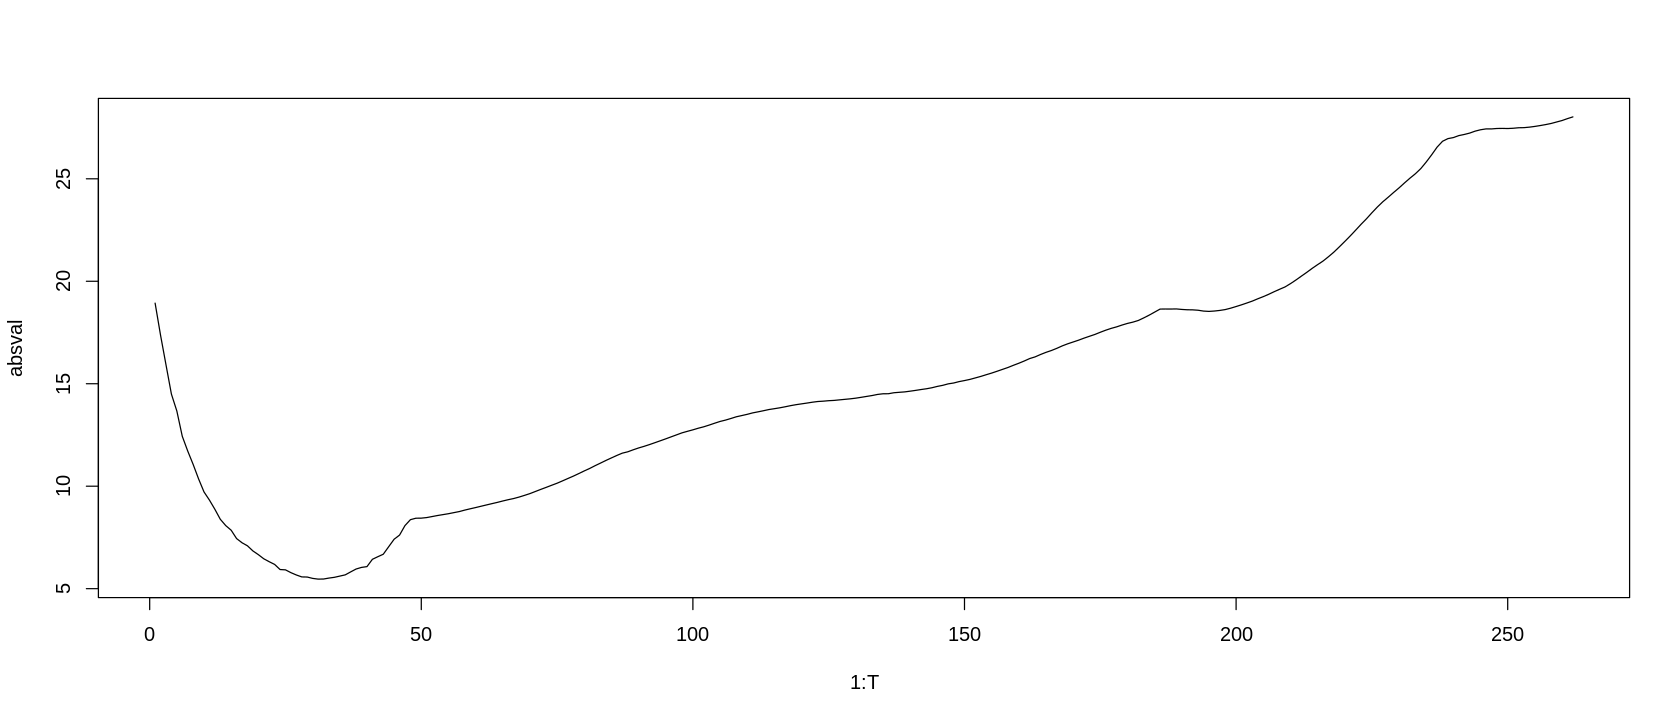

In [ ]:
roots = numeric(T)
absval = numeric(T)
freq = numeric(T)
for(i in 1:T){
  root = 1/polyroot(c(1, - results_smoothed$mnt[i,]))
  roots[i] = root[rev((order(Mod(root))))[1]]
  absval[i] = Mod(roots[i])
  freq[i] = 2*pi/Arg(roots[i])
}
options(repr.plot.height = 6)
plot(1:T, absval, 'l')

Since the modulus of the reciprocal root is greater than 1 for all times, the process is not stationary.